In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.util import montage
from IPython.display import Image, display, SVG, clear_output, HTML
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better

import scipy.sparse as sp
from tensorflow.keras.datasets import mnist as m
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph

MNIST_SIZE = 28

In [2]:
def load_data(k=8, noise_level=0.0, random_state=None):
    """
    Loads the MNIST dataset and a K-NN graph to perform graph signal
    classification, as described by [Defferrard et al. (2016)](https://arxiv.org/abs/1606.09375).
    The K-NN graph is statically determined from a regular grid of pixels using
    the 2d coordinates.

    The node features of each graph are the MNIST digits vectorized and rescaled
    to [0, 1].
    Two nodes are connected if they are neighbours according to the K-NN graph.
    Labels are the MNIST class associated to each sample.

    :param k: int, number of neighbours for each node;
    :param noise_level: fraction of edges to flip (from 0 to 1 and vice versa);

    :return:
        - X_train, y_train: training node features and labels;
        - X_val, y_val: validation node features and labels;
        - X_test, y_test: test node features and labels;
        - A: adjacency matrix of the grid;
    """
    A = _mnist_grid_graph(k)
    if random_state is not None:
        np.random.seed(random_state)
    A = _flip_random_edges(A, noise_level).astype(np.float32)

    (X_train, y_train), (X_test, y_test) = m.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0
    X_train = X_train.reshape(-1, MNIST_SIZE ** 2)
    X_test = X_test.reshape(-1, MNIST_SIZE ** 2)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10000, random_state=random_state)

    return X_train, y_train, X_val, y_val, X_test, y_test, A


def _grid_coordinates(side):
    """
    Returns 2D coordinates for a square grid of equally spaced nodes.
    :param side: int, the side of the grid (i.e., the grid has side * side nodes).
    :return: np.array of shape (side * side, 2).
    """
    M = side ** 2
    x = np.linspace(0, 1, side, dtype=np.float32)
    y = np.linspace(0, 1, side, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    z = np.empty((M, 2), np.float32)
    z[:, 0] = xx.reshape(M)
    z[:, 1] = yy.reshape(M)
    return z


def _get_adj_from_data(X, k, **kwargs):
    """
    Computes adjacency matrix of a K-NN graph from the given data.
    :param X: rank 1 np.array, the 2D coordinates of pixels on the grid.
    :param kwargs: kwargs for sklearn.neighbors.kneighbors_graph (see docs
    [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html)).
    :return: scipy sparse matrix.
    """
    A = kneighbors_graph(X, k, **kwargs).toarray()
    A = sp.csr_matrix(np.maximum(A, A.T))

    return A


def _mnist_grid_graph(k):
    """
    Get the adjacency matrix for the KNN graph.
    :param k: int, number of neighbours for each node;
    :return:
    """
    X = _grid_coordinates(MNIST_SIZE)
    A = _get_adj_from_data(
        X, k, mode='connectivity', metric='euclidean', include_self=False
    )

    return A


def _flip_random_edges(A, percent):
    """
    Flips values of A randomly.
    :param A: binary scipy sparse matrix.
    :param percent: percent of the edges to flip.
    :return: binary scipy sparse matrix.
    """
    if not A.shape[0] == A.shape[1]:
        raise ValueError('A must be a square matrix.')
    dtype = A.dtype
    A = sp.lil_matrix(A).astype(np.bool)
    n_elem = A.shape[0] ** 2
    n_elem_to_flip = round(percent * n_elem)
    unique_idx = np.random.choice(n_elem, replace=False, size=n_elem_to_flip)
    row_idx = unique_idx // A.shape[0]
    col_idx = unique_idx % A.shape[0]
    idxs = np.stack((row_idx, col_idx)).T
    for i in idxs:
        i = tuple(i)
        A[i] = np.logical_not(A[i])
    A = A.tocsr().astype(dtype)
    A.eliminate_zeros()
    return A

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.util import montage
from IPython.display import Image, display, SVG, clear_output, HTML
import networkx as nx
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better

def draw_graph_mpl(g, pos=None, ax=None, layout_func=nx.drawing.layout.kamada_kawai_layout, draw_labels=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    else:
        fig = None
    if pos is None:
        pos = layout_func(g)
    node_color = []
    node_labels = {}
    shift_pos = {}
    for k in g:
        node_color.append(g.nodes[k].get('color', 'green'))
        node_labels[k] = g.nodes[k].get('label', k)
        shift_pos[k] = [pos[k][0], pos[k][1]]
    
    edge_color = []
    edge_width = []
    for e in g.edges():
        edge_color.append(g.edges[e].get('color', 'blue'))
        edge_width.append(g.edges[e].get('width', 1))
    nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5, ax=ax)
    nx.draw_networkx_nodes(g, pos, node_color=node_color, node_shape='s', node_size=400, alpha=0.75, ax=ax)
    if draw_labels:
        nx.draw_networkx_labels(g, shift_pos, labels=node_labels, ax=ax)
    ax.autoscale()
    return fig, ax, pos

In [4]:
xx, yy = np.meshgrid(np.arange(MNIST_SIZE), np.arange(MNIST_SIZE))
node_id = ['X:{:02d}_Y:{:02d}'.format(x, y) for x, y in zip(xx.ravel(), yy.ravel())]

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test, adj = load_data(k=8)

/tmp/ipykernel_2653212/3270426784.py:91: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  A = sp.lil_matrix(A).astype(np.bool)


3


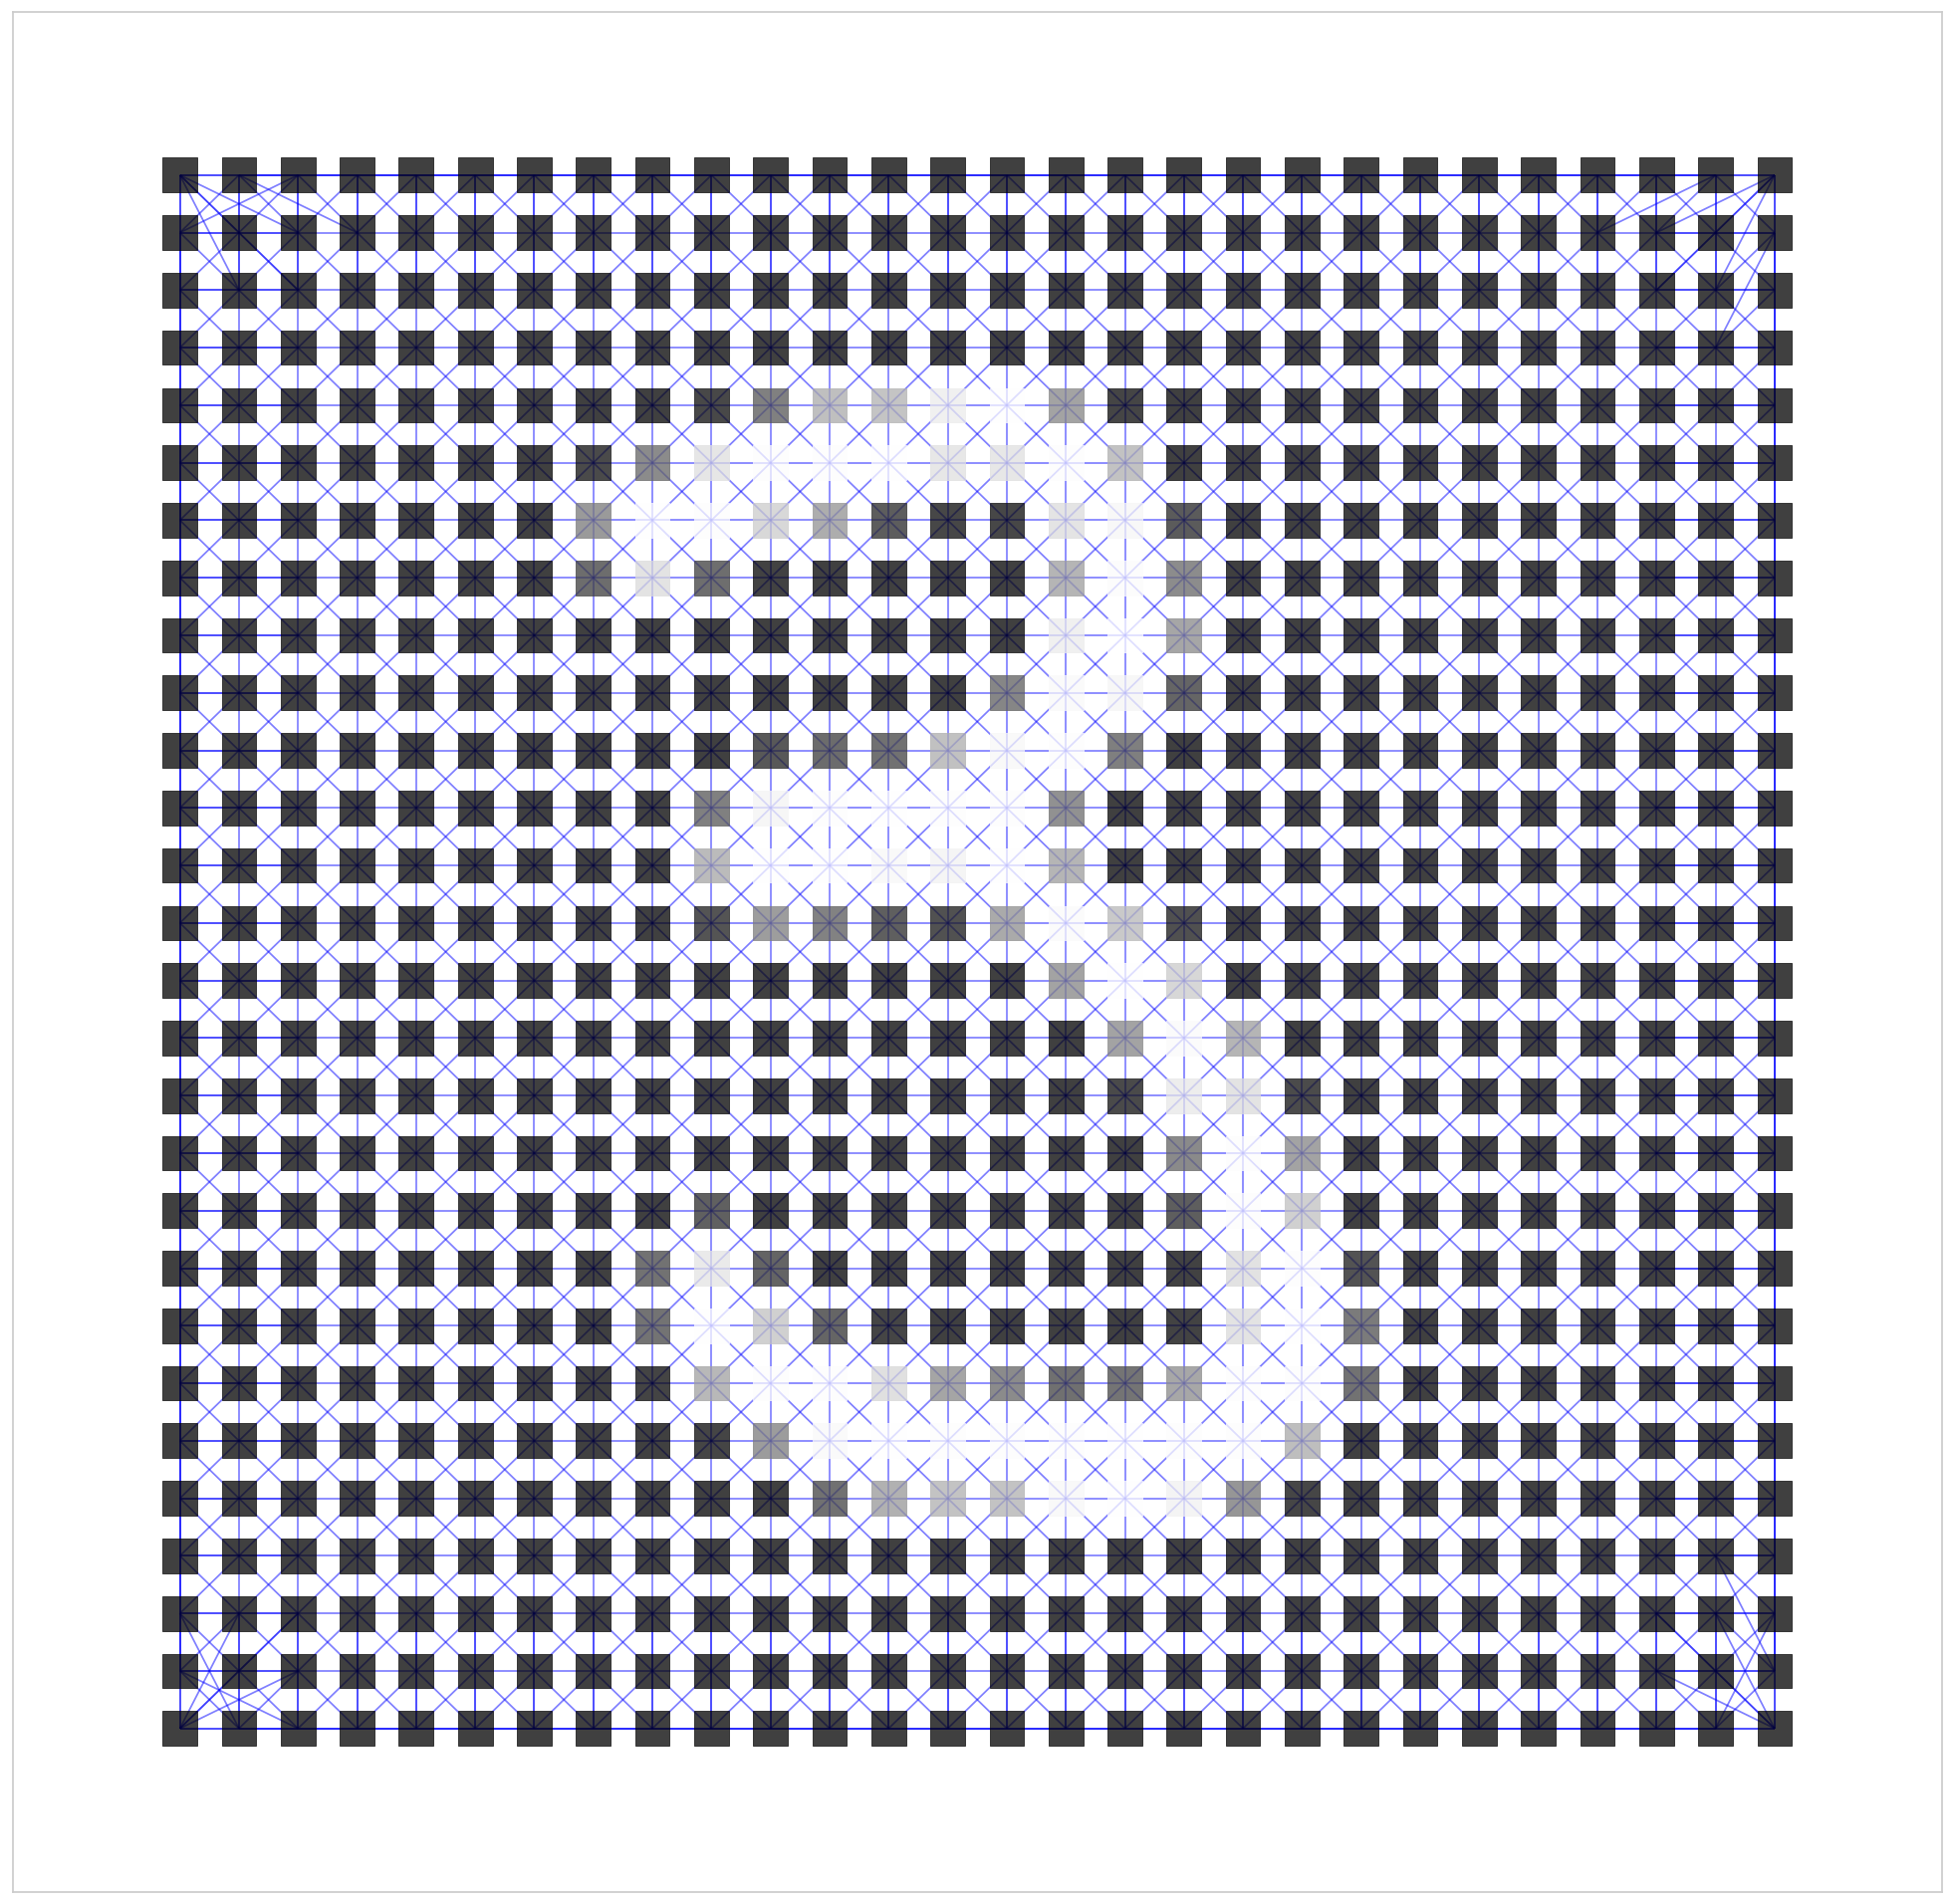

In [6]:
# fig, ax = plt.subplots(figsize=(8, 8))
# ax = draw_graph(A, ax=ax, size_factor=1)
G = nx.from_scipy_sparse_matrix(adj)
idx = 4
for k, val in zip(G.nodes, X_train[idx].reshape((MNIST_SIZE, MNIST_SIZE))[::-1,:].flatten()):
    G.nodes[k]['label'] = node_id[k]
    # G.nodes[k]['color'] = 'red' if val>0 else 'green'
    G.nodes[k]['color'] = val #if val>0 else 'green'
draw_graph_mpl(G, pos=np.stack([xx.ravel(), yy.ravel()], -1), draw_labels=False);
print(y_train[idx])
plt.savefig(str(y_train[idx])+'.png', bbox_inches='tight')

In [7]:
X_train[idx].shape

(784,)